In [4]:
import spikeinterface.full as si
import probeinterface as pif
from probeinterface.plotting import plot_probe
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import os

In [ ]:
%matplotlib widget

Text(0.5, 1.0, 'NPX 1')

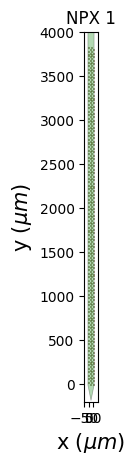

In [5]:
# path to meta file
meta_filename = '/home/manishm/RR2_NPX/sub-M388/M388-2023-11-20_2_g0/M388-2023-11-20_2_g0_imec0/M388-2023-11-20_2_g0_tcat.imec0.ap.meta'
probe = pif.read_spikeglx(meta_filename)
fig,ax = plt.subplots()
plot_probe(probe, ax=ax)
ax.set_ylim([-200, 4000])
ax.set_title('NPX 1')

In [6]:
raw_rec = si.read_spikeglx('/home/manishm/RR2_NPX/sub-M388/M388-2023-11-20_2_g0/M388-2023-11-20_2_g0_imec0', \
                           stream_name='imec0.ap')
# non_neuronal = si.read_spikeglx(npx_path, stream_name='nidq', all_annotations=True)
# Turns out only the the analog streams are read from thhe .nidq file, and not the digital events.

In [7]:
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
print('bad_channel_ids, channel_labels')
for bad_channel_id in bad_channel_ids:
    index = int(bad_channel_id.split('AP')[1])
    print('{}, {}'.format(bad_channel_id, channel_labels[index]))

bad_channel_ids, channel_labels
imec0.ap#AP191, dead
imec0.ap#AP364, out
imec0.ap#AP365, out
imec0.ap#AP366, out
imec0.ap#AP367, out
imec0.ap#AP368, out
imec0.ap#AP369, out
imec0.ap#AP370, out
imec0.ap#AP371, out
imec0.ap#AP372, out
imec0.ap#AP373, out
imec0.ap#AP374, out
imec0.ap#AP375, out
imec0.ap#AP376, out
imec0.ap#AP377, out
imec0.ap#AP378, out
imec0.ap#AP379, out
imec0.ap#AP380, out
imec0.ap#AP381, out
imec0.ap#AP382, out
imec0.ap#AP383, out


In [8]:
#Remove bad channels after crosschecking with SpikeGLX viewer
rec1 = rec1.remove_channels(bad_channel_ids)
np.shape(rec1.get_channel_locations())

(363, 2)

# **Kilosort requires a binary file as input so the code below does that**

In [9]:
ks_working_folder = '/ks2_t'
# Make sure it exits and is in on the fastest memory drive
os.path.exists(ks_working_folder)

True

In [11]:
# Run this only if binary recording hasn't been written yet
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
rec = rec1.save(folder=os.path.join(ks_working_folder,'preprocess'), format='binary', **job_kwargs)

write_binary_recording with n_jobs = 40 and chunk_size = 30000


write_binary_recording:   0%|          | 0/1592 [00:00<?, ?it/s]

## **Run this only if the binary recording has already been written and progress was lost after that step**

In [ ]:
# Number of good channels
gc = 363;
rec = si.BinaryRecordingExtractor('/ks2_t/preprocess/traces_cached_seg0.raw', 30000, 'int16', gc) 
# Hacky Steps because Binary recordings does not contain the following properties
rec.set_channel_locations(rec1.get_channel_locations())
rec.set_probe(rec1.get_probe())
rec.set_property('contact_vector', rec1.get_property('contact_vector'))
rec.annotate(is_filtered=True)

In [ ]:
# check manually for drifts (Straight lines are good, slanting lines indeicate drift)
rec2 = si.common_reference(rec1, operator="median", reference="global")
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(rec2,  method='locally_exclusive',
                     detect_threshold=5, **job_kwargs)
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peak_locations = localize_peaks(rec2, peaks, method='center_of_mass', **job_kwargs)

fs = rec2.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.', alpha=0.002)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(rec, ax=ax, with_channel_ids=True)
ax.set_ylim(1000, 1500)

ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

In [12]:
ks2_path = '/home/manishm/Kilosort'
si.Kilosort2_5Sorter.set_kilosort2_5_path(ks2_path)
si.Kilosort2_5Sorter.is_installed() # Should return true, if not change path accordingly

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/manishm/Kilosort


True

In [13]:
ks2_5_params = si.get_default_sorter_params('kilosort2_5')
print(ks2_5_params)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'nblocks': 5, 'sig': 20, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'do_correction': True, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 16, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}


In [14]:
sorting = si.run_sorter('kilosort2_5', rec, output_folder=os.path.join(ks_working_folder, 'ks2_output'),
                        verbose=True, remove_existing_folder=False, **ks2_5_params)

RUNNING SHELL SCRIPT: /ks2_t/ks2_output/sorter_output/run_kilosort2_5.sh


                            < M A T L A B (R) >

                  Copyright 1984-2021 The MathWorks, Inc.

                  R2021b (9.11.0.1769968) 64-bit (glnxa64)

                             September 17, 2021



 

To get started, type doc.

For product information, visit www.mathworks.com.

 

Time   0s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time   5s. Loading raw data and applying filters... 

Time 128s. Finished preprocessing 728 batches. 

Drift correction ENABLED

pitch is 20 um

0.23 sec, 1 batches, 3915 spikes 

22.73 sec, 101 batches, 453068 spikes 

44.02 sec, 201 batches, 909353 spikes 

65.08 sec, 301 batches, 1328724 spikes 

85.83 sec, 401 batches, 1849175 spikes 

106.63 sec, 501 batches, 2307832 spikes 

127.44 sec, 601 batches, 2753494 spikes 

148.28 sec, 701 batches, 3231953 spikes 

153.91 sec, 728 batches, 3376817 spik

In [15]:
sorting

KiloSortSortingExtractor: 241 units - 1 segments - 30.0kHz

In [ ]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
we = si.extract_waveforms(rec, sorting, folder=os.path.join(ks_working_folder, 'si_waveforms'), ms_before=1.5, ms_after=2.5, max_spikes_per_unit=1000, **job_kwargs)
# Change the above line if more spikes are needed or if the waveform length needs to be different

In [ ]:
si.export_to_phy(we, os.path.join(ks_working_folder, 'si_phy'), **job_kwargs)

# LFP analysis

In [ ]:
lfp.get_property_keys()

In [ ]:
bad_channel_ids, channel_labels = si.detect_bad_channels(lfp)

In [ ]:
lfp2 = si.phase_shift(lfp)
lfp3 = si.common_reference(lfp2, operator="median", reference="global") # obviously wrong thing to do

# here we use static plot using matplotlib backend
fig, axs = plt.subplots(ncols=3, figsize=(20, 10))

si.plot_timeseries(lfp, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_timeseries(lfp2, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_timeseries(lfp3, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
for i, label in enumerate(('original', 'phase_shift', 'final')):
    axs[i].set_title(label)
    
plt.show()